Импортирование библиотек

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from functools import reduce

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

import joblib

from sklearn.linear_model import ElasticNet
from sklearn.ensemble import StackingRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

Загружаем данные

In [2]:
train_xlsx = pd.read_excel("../data/train.xlsx").to_csv("../csvs/train.csv", sep=",", index = False)
test_xlsx = pd.read_excel("../data/test.xlsx").to_csv("../csvs/test.csv", sep=",", index = False)
gruz = pd.read_excel("../data/Грузоперевозки.xlsx").to_csv("../csvs/cargo.csv", sep=",", index = False)
rynok_data = pd.read_excel("../data/Данные рынка стройматериалов.xlsx").to_csv("../csvs/market_data.csv", sep=",", index = False)
lme = pd.read_excel("../data/Индекс LME.xlsx").to_csv("../csvs/index_LME.csv",sep=",", index = False)
macro_pok = pd.read_excel("../data/Макропоказатели.xlsx").to_csv("../csvs/macro.csv", sep=",", index = False)
pok_ryn = pd.read_excel("../data/Показатели рынка металла.xlsx").to_csv("../csvs/metal_market.csv", sep=",", index = False)
topl = pd.read_excel("../data/Топливо.xlsx").to_csv("../csvs/fuel.csv", sep=",", index = False)
syrye_price = pd.read_excel("../data/Цены на сырье.xlsx").to_csv("../csvs/material_price.csv", sep=",", index = False)

train = pd.read_csv("../csvs/train.csv")
test = pd.read_csv("../csvs/test.csv")

train = pd.concat([train, test])
train.to_csv('../data/price_data.csv')
# data_oned = train.copy()

cargo = pd.read_csv("../csvs/cargo.csv")
market_data = pd.read_csv("../csvs/market_data.csv")
index_LME = pd.read_csv("../csvs/index_LME.csv")
macro = pd.read_csv("../csvs/macro.csv")
metal_market = pd.read_csv("../csvs/metal_market.csv")
fuel = pd.read_csv("../csvs/fuel.csv")
material_price = pd.read_csv("../csvs/material_price.csv")

Приводим колонку с ценой к правильному типу и переименновываем

In [3]:
index_LME['цена'] = pd.to_numeric(index_LME['цена'], errors='coerce')
index_LME['цена'] = index_LME['цена'].dropna().astype(float)
index_LME.rename(columns={'дата': 'dt'}, inplace=True) 

Создаем список со всеми данными

In [4]:
add_data = [
    train,
    cargo,
    market_data,
    index_LME,
    macro,
    metal_market,
    fuel,
    material_price
]

Вычисляем временные отрывки

In [5]:
for i, data in enumerate(add_data):
    data['dt'] = pd.to_datetime(data['dt'], format='%Y-%m-%d')
    add_data[i] = data.set_index('dt').resample('W-MON').mean().reset_index()
    print(f"{data['dt'].min()} - {data['dt'].max()}")
    
data['dt'] = data['dt'].dt.date

2015-01-05 00:00:00 - 2023-03-13 00:00:00
2017-09-06 00:00:00 - 2023-06-14 00:00:00
2021-04-30 00:00:00 - 2023-04-30 00:00:00
2021-02-12 00:00:00 - 2023-03-27 00:00:00
2016-01-31 00:00:00 - 2023-06-16 00:00:00
2016-03-31 00:00:00 - 2023-03-31 00:00:00
2017-02-28 00:00:00 - 2023-05-31 00:00:00
2015-02-09 00:00:00 - 2023-03-13 00:00:00


Получаем временной отрывок, в котором есть все колонки и сортируем по дате

In [6]:
min_date = max(data['dt'].min() for data in add_data)
max_date = min(data['dt'].max() for data in add_data)
print(min_date, '  ------------  ', max_date)

for data in add_data:
    data = data[(data['dt'] >= min_date) & (data['dt'] <= max_date)].reset_index(drop=True)
train = train.set_index('dt')

2021-05-03 00:00:00   ------------   2023-03-13 00:00:00


График распределения цены

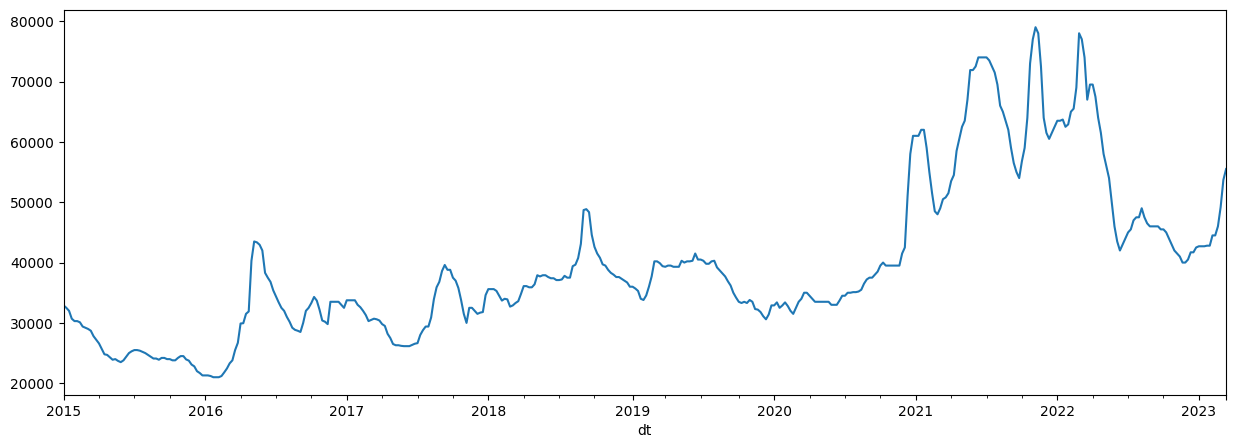

In [7]:
train['Цена на арматуру'].plot(figsize=(15, 5))
plt.show()

In [8]:
decompose = seasonal_decompose(train['Цена на арматуру'], period=12)

График сезонности, тренда и неконтроллируемой ошибки

<Axes: title={'center': 'Остаток'}, xlabel='dt'>

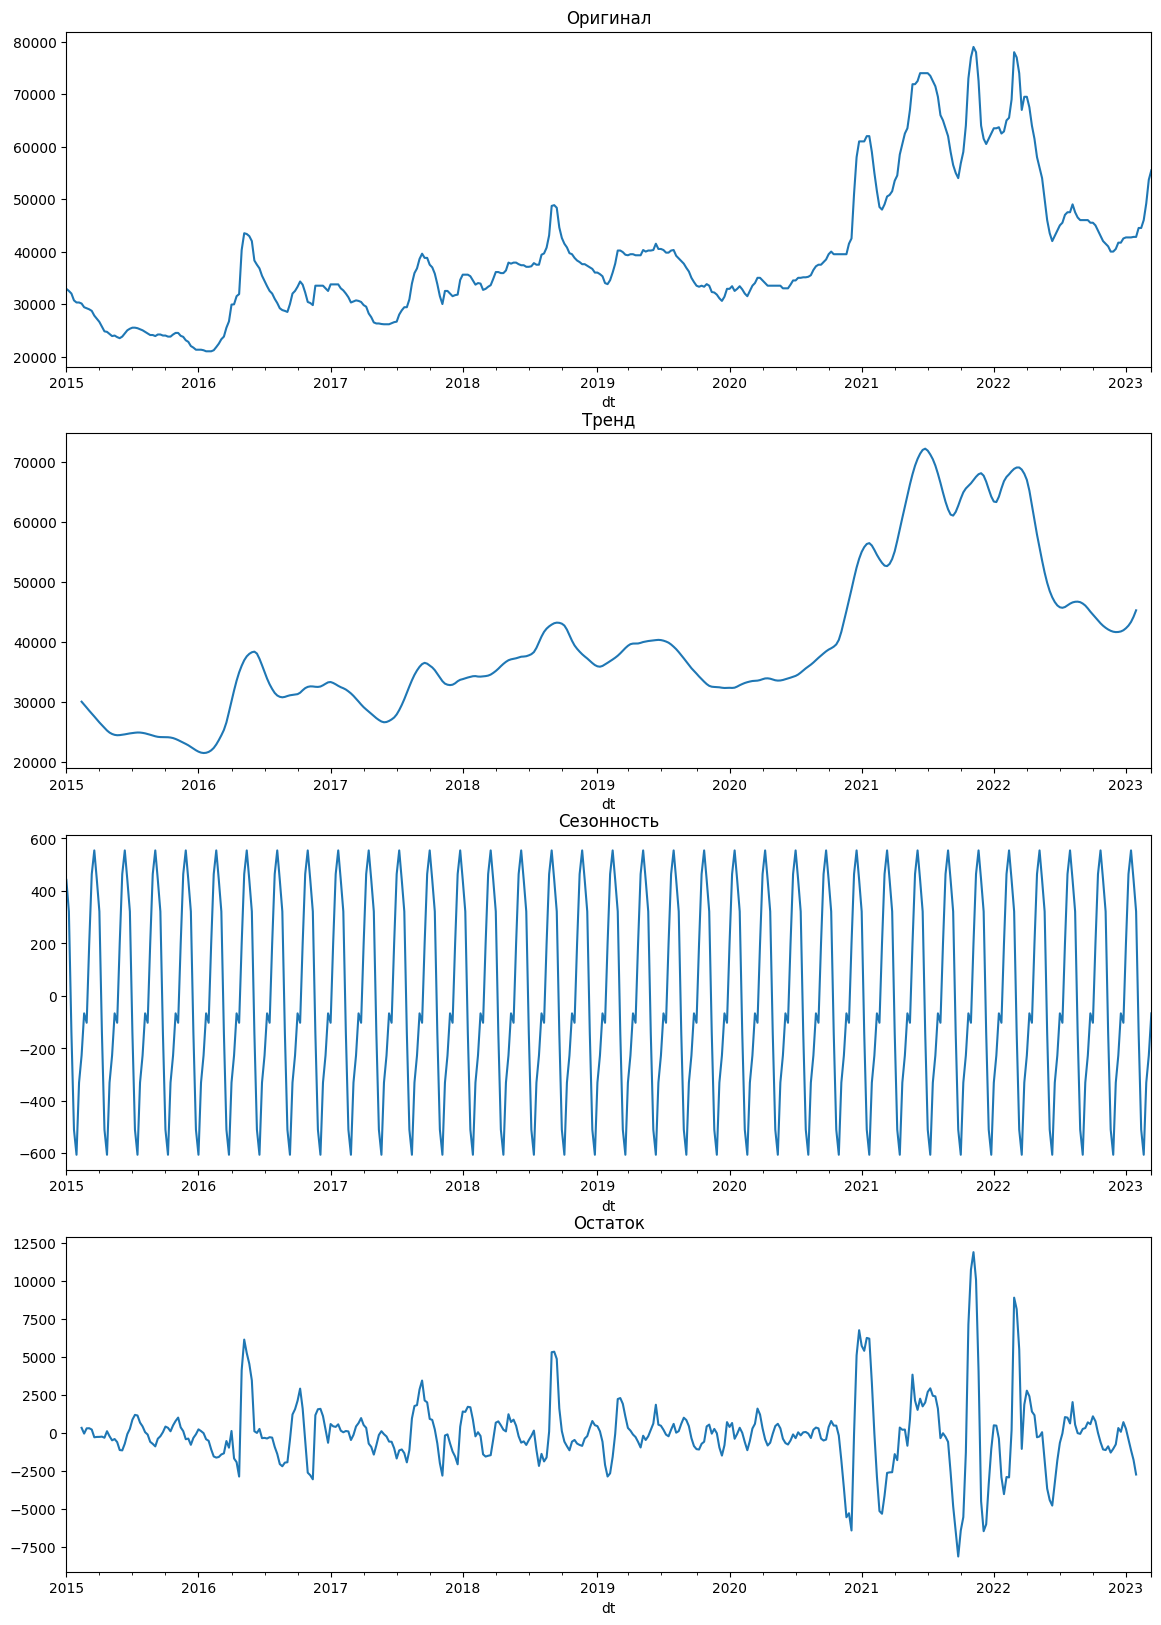

In [9]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(14, 20))

ax[0].set_title('Оригинал')
ax[1].set_title('Тренд')
ax[2].set_title('Сезонность')
ax[3].set_title('Остаток')


# plt.xlabel('penis')

decompose.observed.plot(ax=ax[0])
decompose.trend.plot(ax=ax[1])
decompose.seasonal.plot(ax=ax[2])
decompose.resid.plot(ax=ax[3])

График автокорреляции

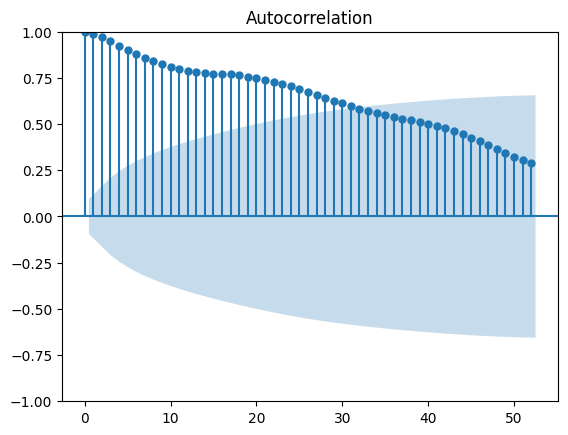

In [10]:
plot_acf(train['Цена на арматуру'], lags=52)  
plt.show()

Объединяем все данные в одну таблицу

In [11]:
df_merged = reduce(lambda left, right: pd.merge(left, right, on='dt', how='inner'), add_data)
df_merged.set_index('dt', inplace=True)
df_merged.index = df_merged.index.date
df_merged.index = pd.to_datetime(df_merged.index)

df_merged.to_csv('df_merged1.csv')
df_merged.head()

Цена на арматуру  Индекс стоимости грузоперевозок  \
2021-05-03           62500.0                           1060.0   
2021-05-10           63500.0                           1094.0   
2021-05-17           67000.0                           1073.0   
2021-05-24           71900.0                           1078.0   
2021-05-31           71900.0                           1096.0   

            Импорт цемента ЖД  Экспорт цемента ЖД  Отгрузка цемента хоппер ЖД  \
2021-05-03             40.751              27.530                     987.540   
2021-05-10                NaN                 NaN                         NaN   
2021-05-17                NaN                 NaN                         NaN   
2021-05-24                NaN                 NaN                         NaN   
2021-05-31             69.979              43.423                    1071.832   

            Отгрузка цемента остальные ЖД  Производство цемента  \
2021-05-03                        201.757                2.3891   
2021-05-10                            NaN                   NaN   
2021-05-17                            NaN                   NaN   
2021-05-24                            NaN                   NaN   
2021-05-31                        256.733                2.7115   

            Импорт цемента  Экспорт цемента  Потребление цемента  ...  \
2021-05-03       52.331737         31.49115             2.290941  ...   
2021-05-10             NaN              NaN                  NaN  ...   
2021-05-17             NaN              NaN                  NaN  ...   
2021-05-24             NaN              NaN                  NaN  ...   
2021-05-31       79.639340         50.16415             2.670775  ...   

            Лом_3А, РФ FCA ж/д Свердловская обл, руб./т, без НДС  \
2021-05-03                                                NaN      
2021-05-10                                                NaN      
2021-05-17                                                NaN      
2021-05-24                                                NaN      
2021-05-31                                                NaN      

            Чугун_CFR Турция, $/т  \
2021-05-03                  590.0   
2021-05-10                  613.5   
2021-05-17                  665.0   
2021-05-24                  670.0   
2021-05-31                  667.5   

            ЖРС_Средневзвешенная цена окатыши Fe 62-65,5%, Россия FCA руб./т, без НДС  \
2021-05-03                                            12736.0                           
2021-05-10                                            12736.0                           
2021-05-17                                            12736.0                           
2021-05-24                                            12736.0                           
2021-05-31                                            13956.0                           

            ЖРС_Средневзвешенная цена концентрат Fe 64-68%, Россия FCA руб./т, без НДС  \
2021-05-03                                            10537.0                            
2021-05-10                                            10537.0                            
2021-05-17                                            10537.0                            
2021-05-24                                            10537.0                            
2021-05-31                                            10279.0                            

            ЖРС_Средневзвешенная цена аглоруда Fe 52-60%, Россия FCA руб./т, без НДС  \
2021-05-03                                             4439.0                          
2021-05-10                                             4439.0                          
2021-05-17                                             4439.0                          
2021-05-24                                             4439.0                          
2021-05-31                                             4420.0                          

            ЖРС_Средневзвешенная цена за 1 % Fe в аглор

Удаляем пустые столбцы и заполняем другие пропуски

In [12]:
df_cleaned = df_merged.dropna(axis=1, how='all')
df_cleaned.interpolate(method='linear', inplace=True)

print(df_cleaned.isnull().sum().sum())

1124


График пропусков

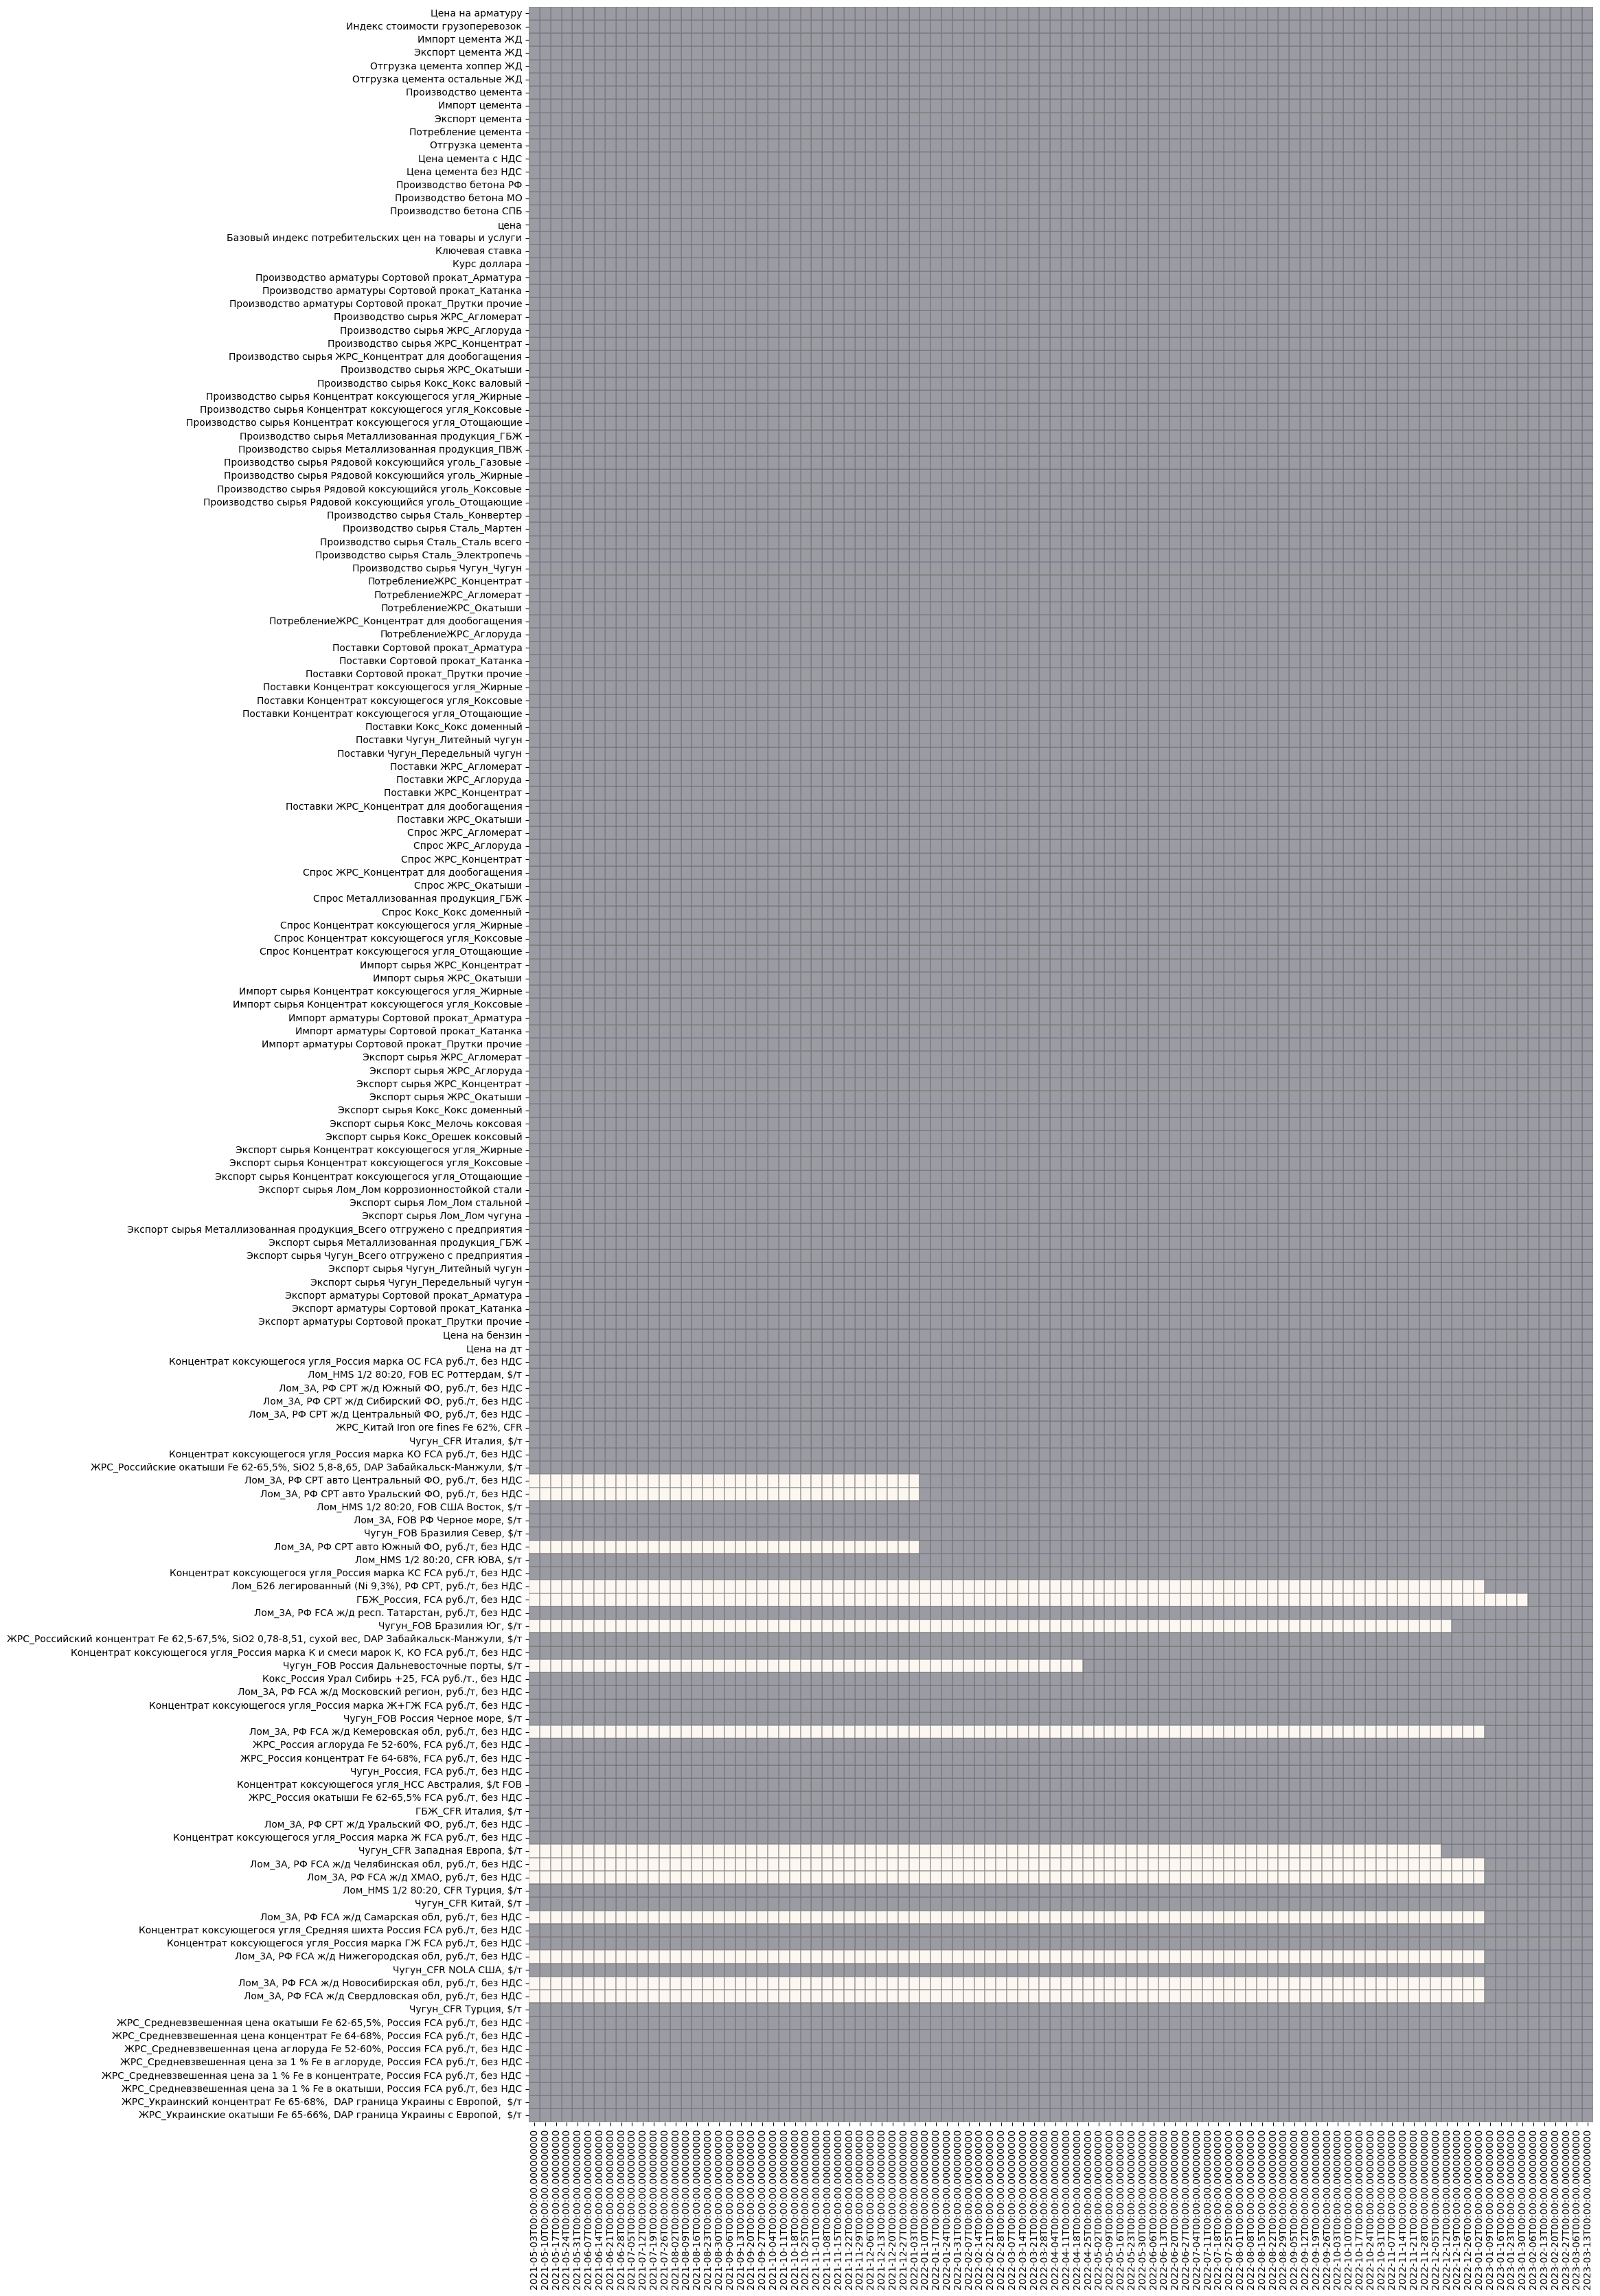

In [13]:
plt.figure(figsize=(20, 40)) 
sns.heatmap(df_cleaned.T.isnull(), cbar=False, linewidths=0.1, linecolor='gray', alpha=0.4)
plt.show()

Доочищаем пропуски

In [14]:
print(df_cleaned.shape)
df_cleaned.dropna(axis=1, inplace=True)
print(df_cleaned.shape)

(98, 160)
(98, 145)


График пропусков

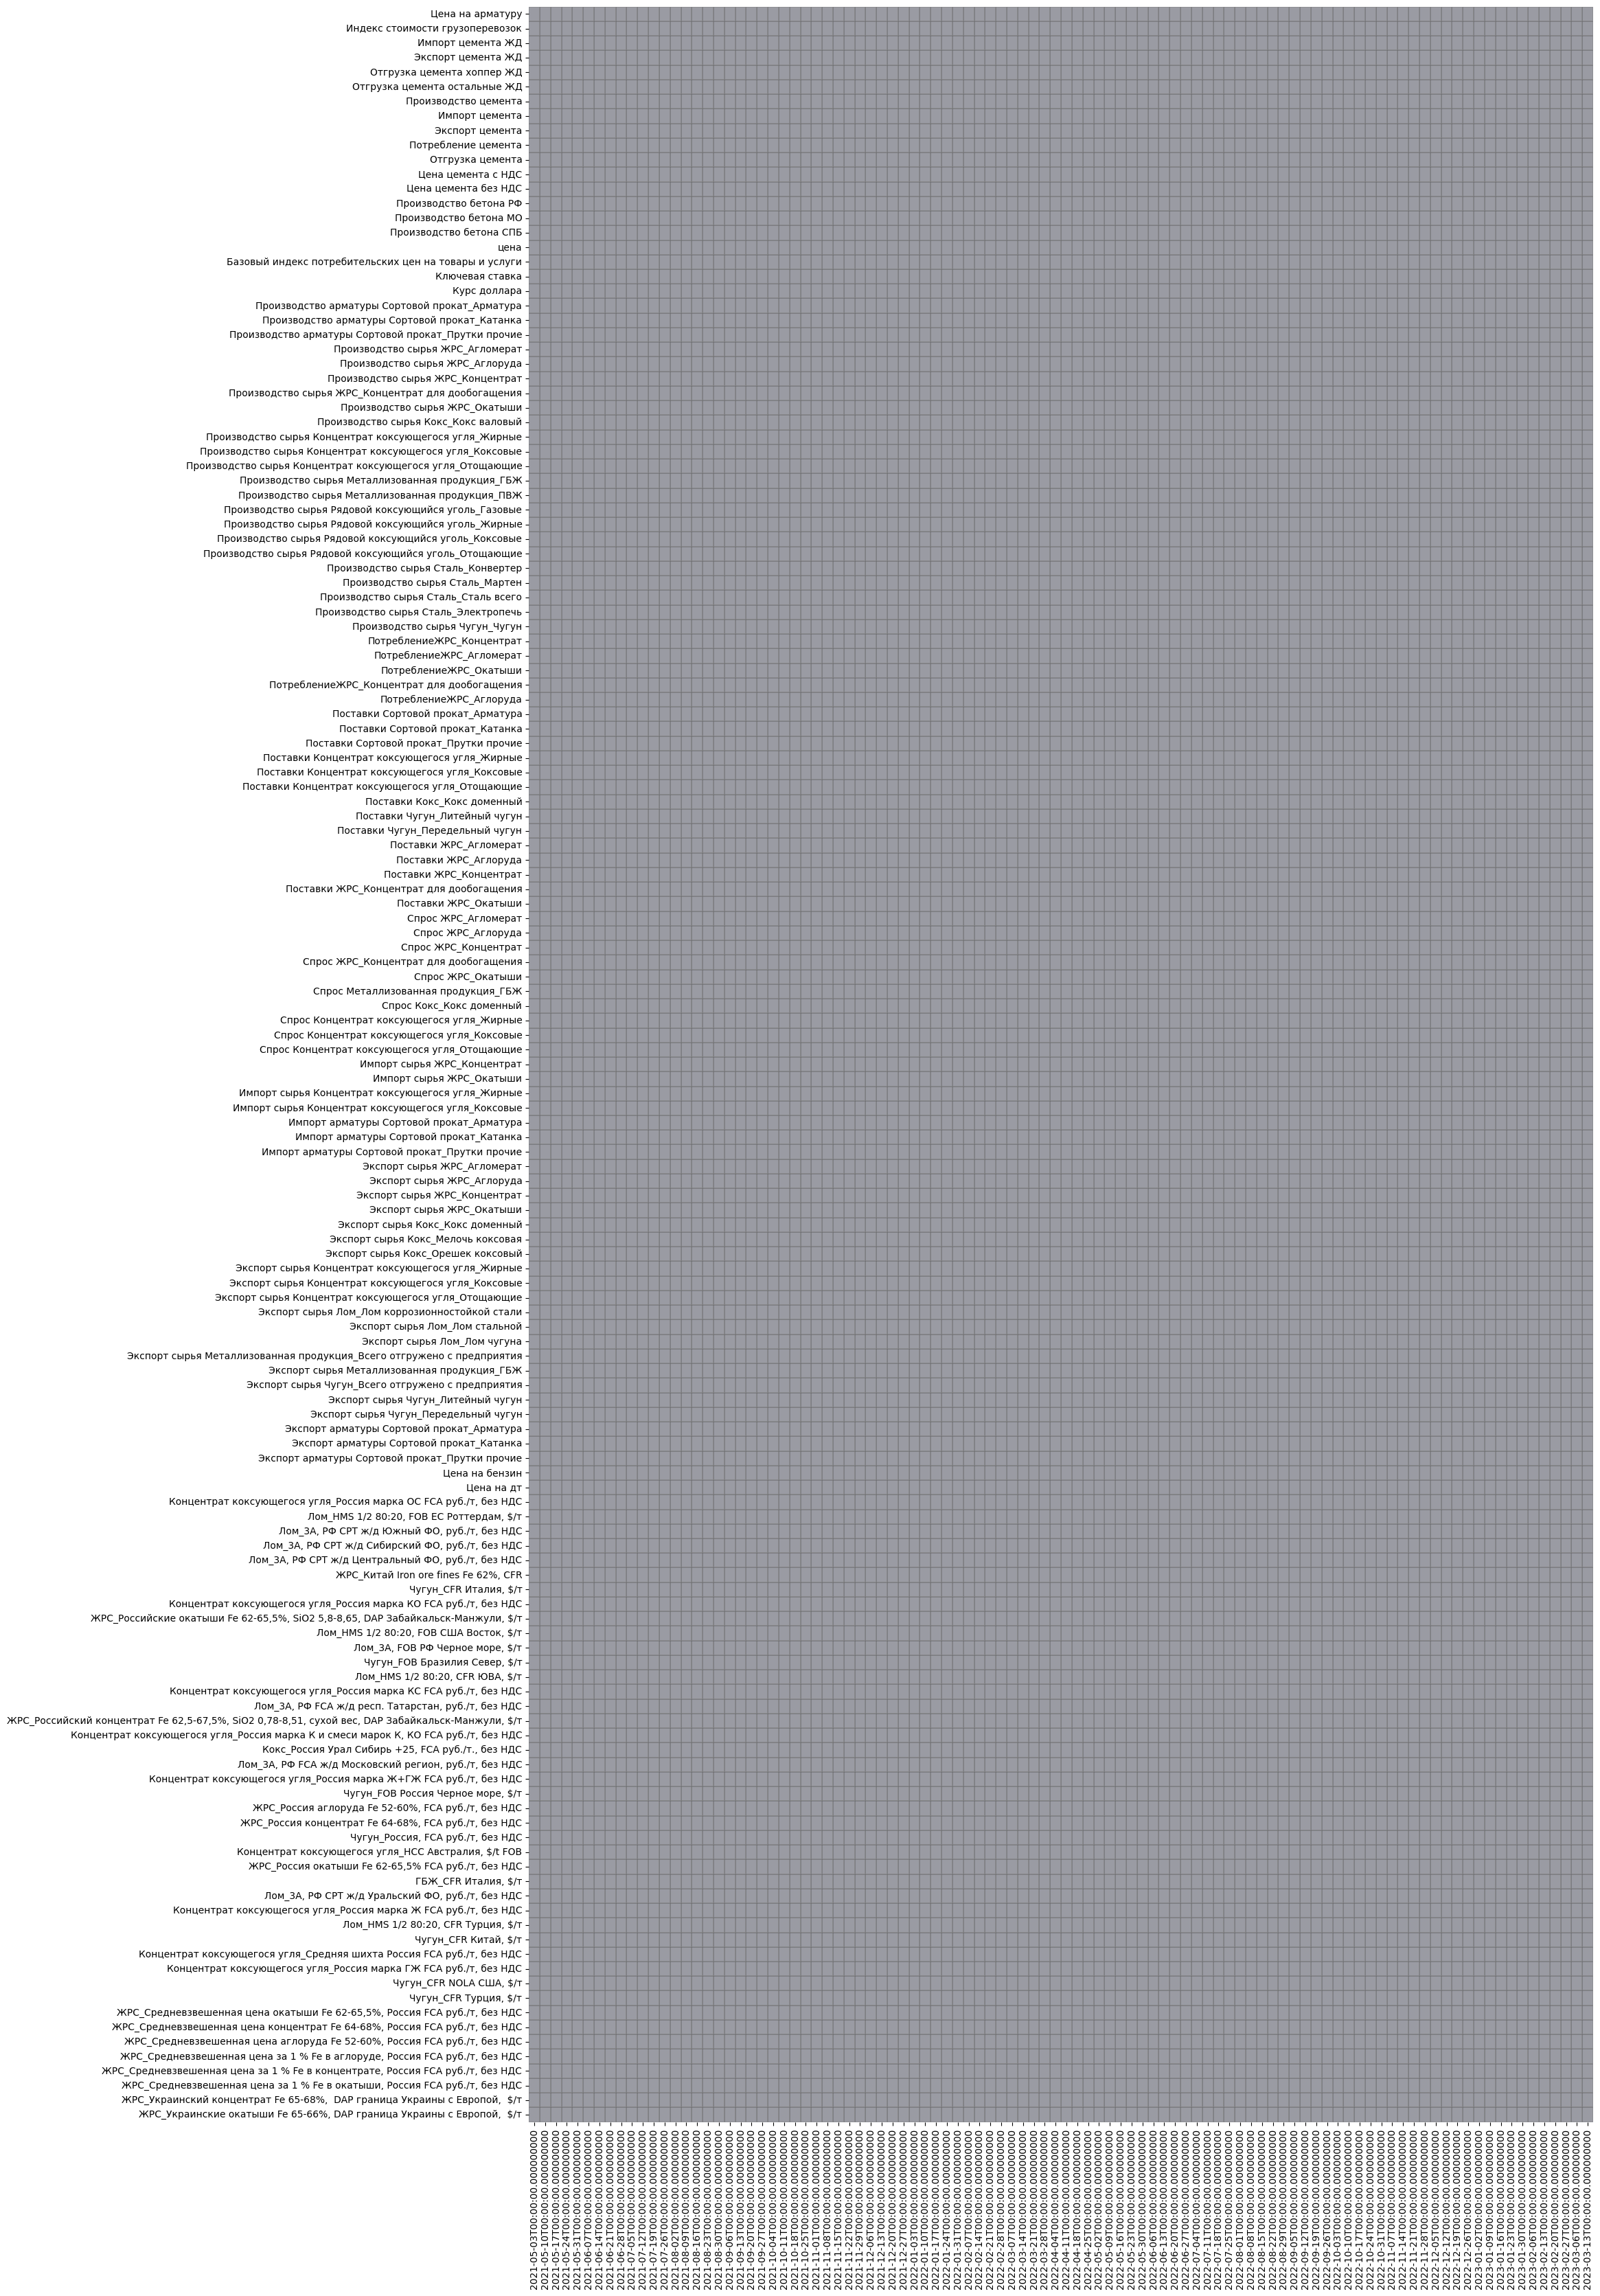

In [15]:
plt.figure(figsize=(20, 40)) 
sns.heatmap(df_cleaned.T.isnull(), cbar=False, linewidths=0.1, linecolor='gray', alpha=0.4)
plt.show()

График распределения цены за новый промежуток

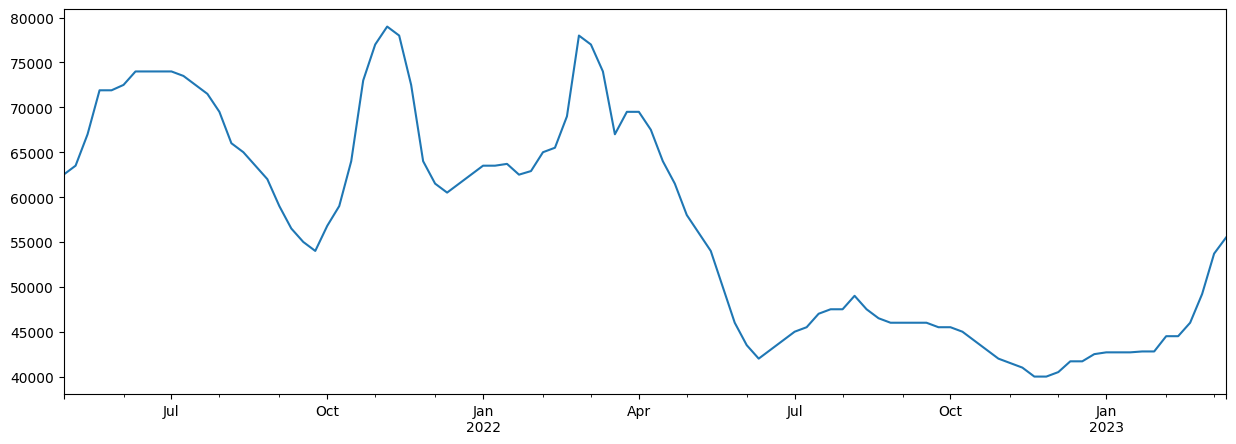

In [16]:
df_cleaned['Цена на арматуру'].plot(figsize=(15, 5))
plt.show()

График нулевых значений

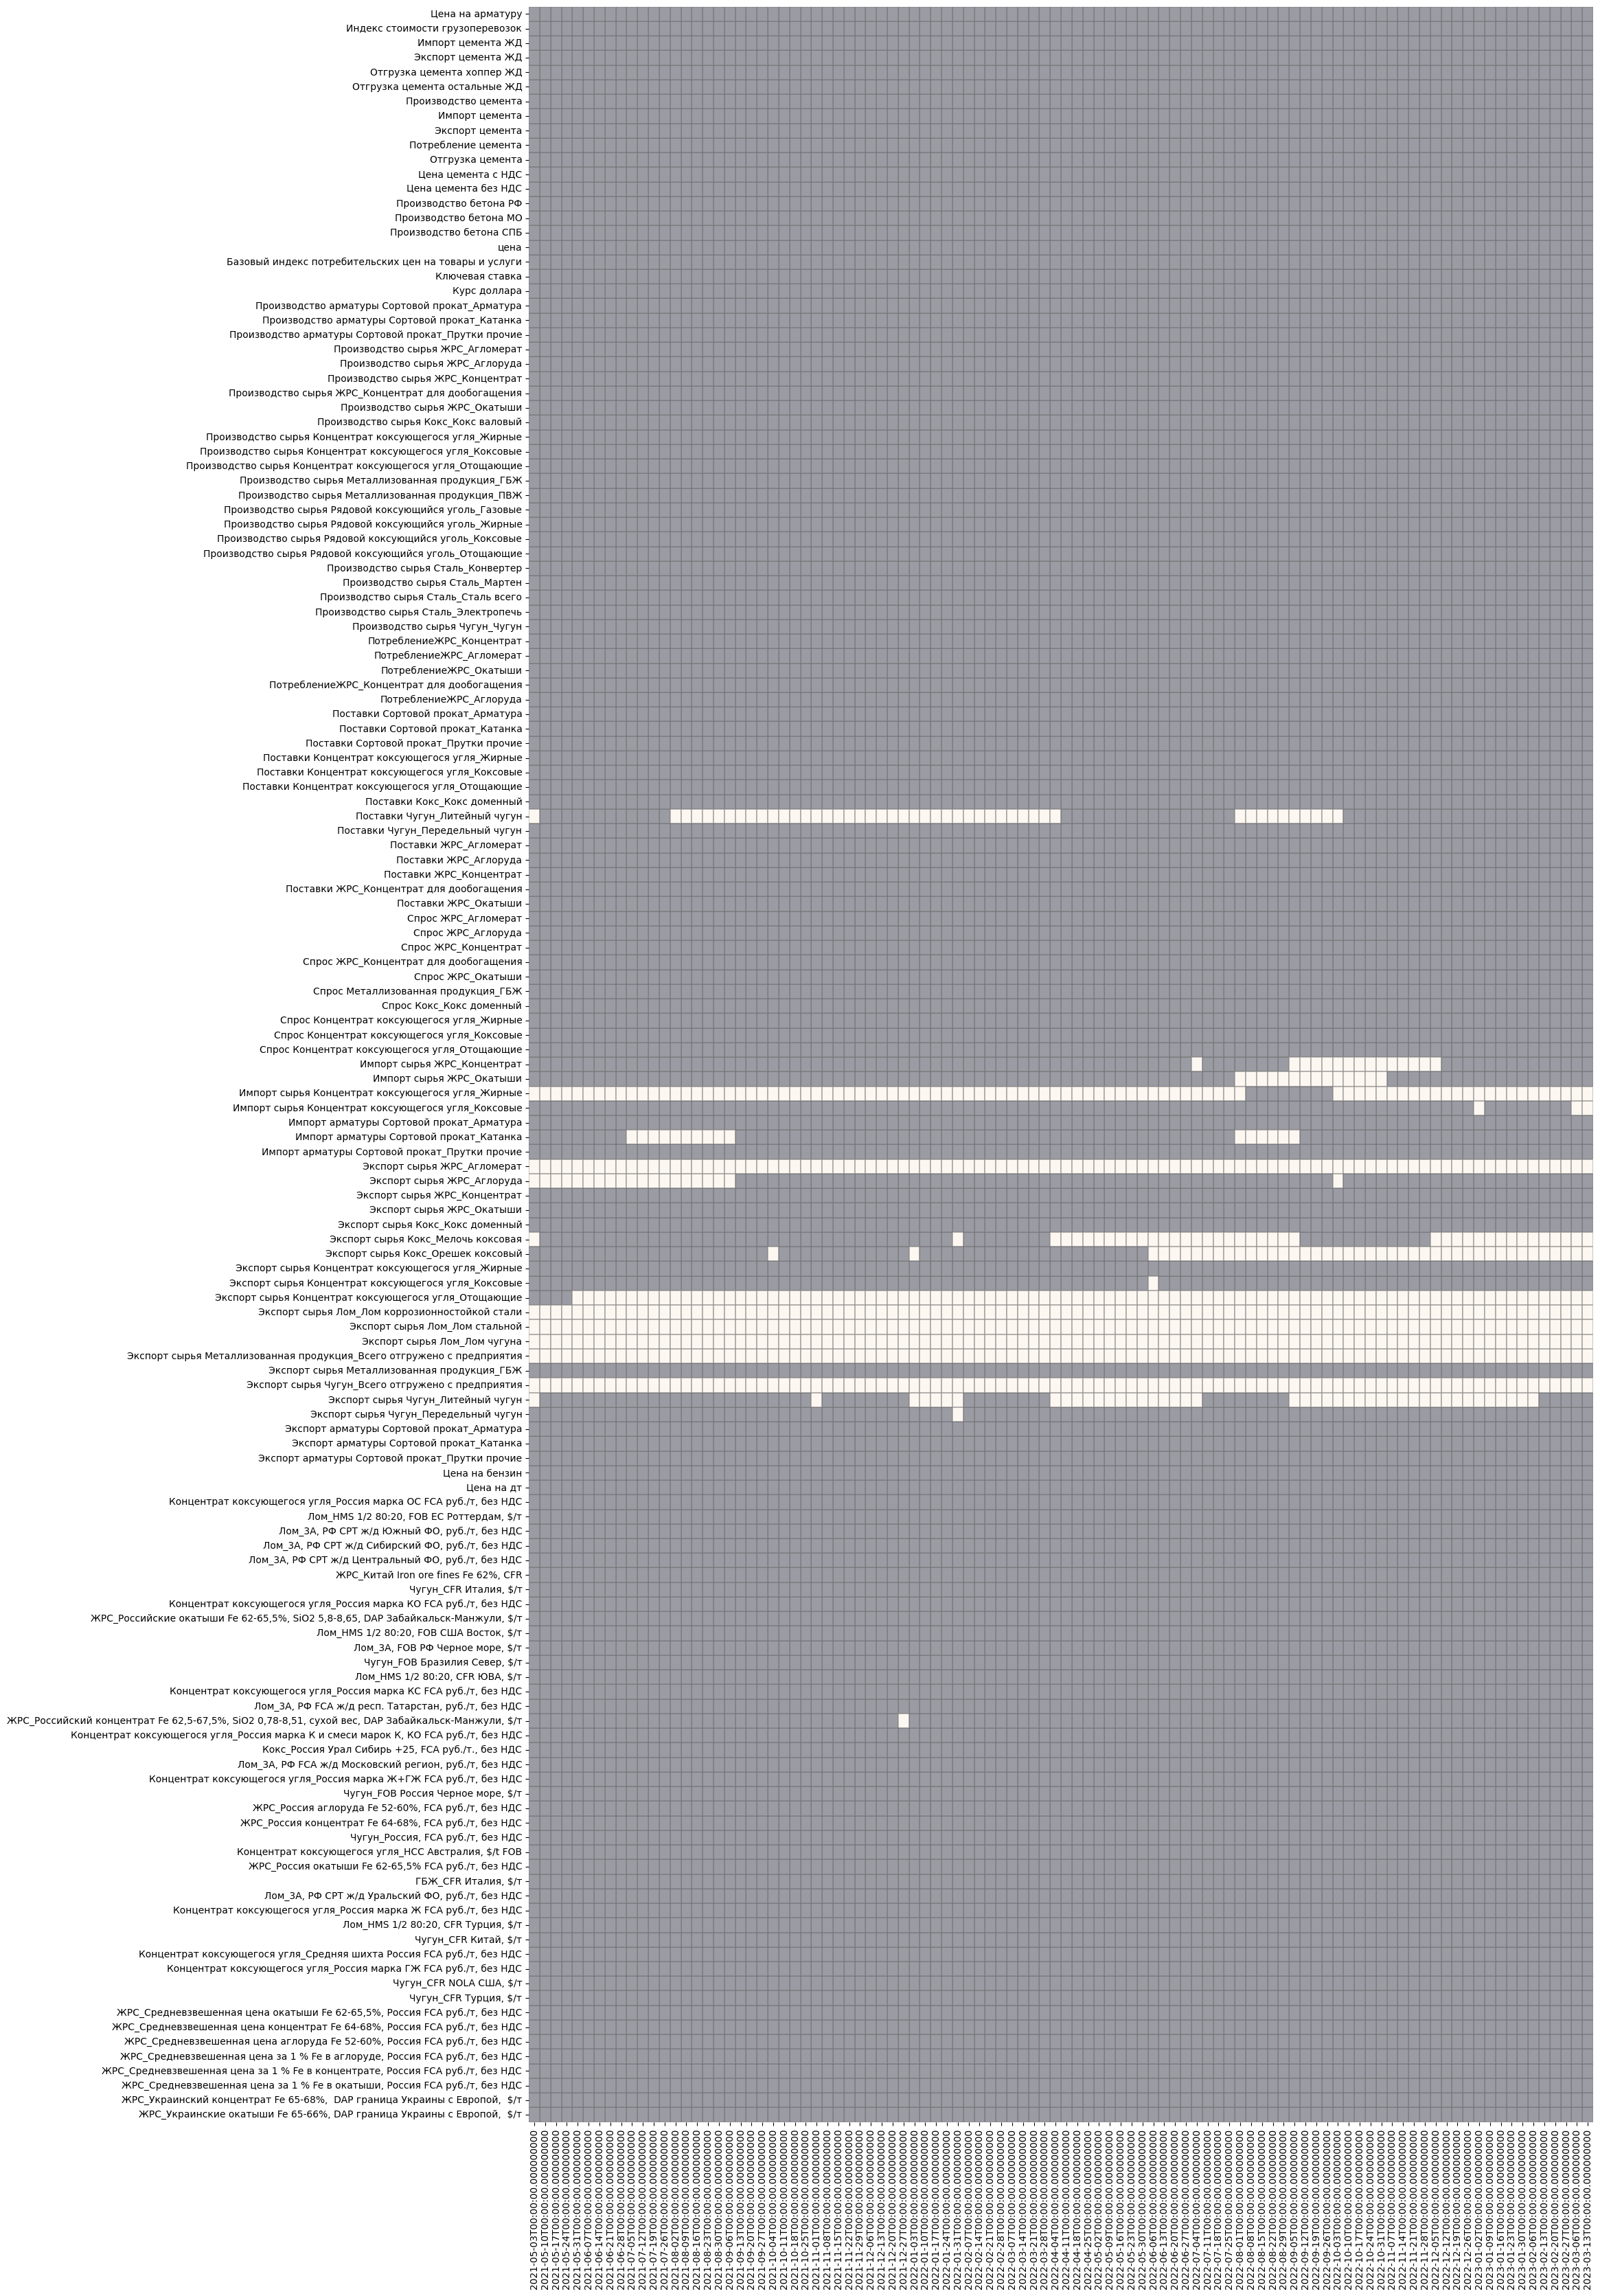

In [17]:
plt.figure(figsize=(20, 40)) 
sns.heatmap(df_cleaned.T==0, cbar=False, linewidths=0.1, linecolor='gray', alpha=0.4)
plt.show()

Удаляем столбцы с большим количеством нулей

In [18]:
df_cleaned = df_cleaned.loc[:, (df_cleaned == 0.0).mean() <= 0.8]

График автокорреляции

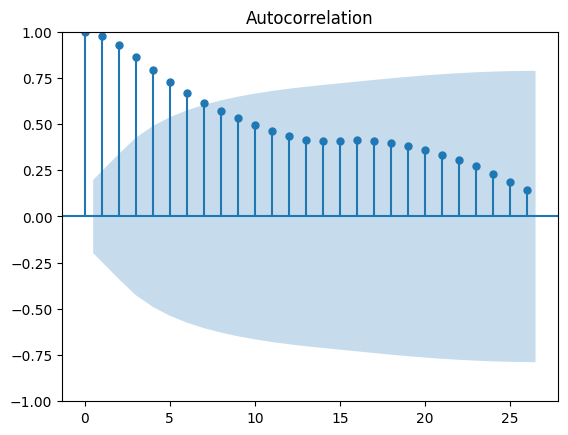

In [19]:
plot_acf(df_cleaned['Цена на арматуру'], lags=26) 
plt.show()

Проверяем стационарность ряда

In [20]:
def check_stationarity(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    
check_stationarity(df_cleaned['Цена на арматуру'])  

ADF Statistic: -2.1271051502672043
p-value: 0.23375606345581706


Стабилизируем ряд

In [21]:
df_cleaned = df_cleaned.rename(columns={'Цена на арматуру':'price'})

df_oned = df_cleaned.copy()

df_cleaned['price_diff'] = df_cleaned['price'] - df_cleaned['price'].shift(1)
df_cleaned['price_seasonal_diff'] = df_cleaned['price'] - df_cleaned['price'].shift(12)
df_cleaned.dropna(inplace=True)

check_stationarity(df_cleaned['price_diff'])

ADF Statistic: -4.6274311396714625
p-value: 0.00011493858964109401


Создаем лаги

In [22]:
def create_lag_features(df, target_col, lags=[1, 4, 8, 12]):
    for lag in lags:
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
    corr_threshold = 0.05
    lag_corr = df.corr()[target_col].abs()
    useful_lags = lag_corr[lag_corr > corr_threshold].index.tolist()
    return df[useful_lags]

df = create_lag_features(df_cleaned, target_col='price', lags=[1, 4, 8, 12])
df.fillna(df.median(), inplace=True) 

C:\Users\User\AppData\Local\Temp\ipykernel_15404\1849797235.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(df.median(), inplace=True)


Делим данные на train и test

In [23]:
train_size = int(len(df) * 0.8)
train_mod, test_mod = df.iloc[:train_size], df.iloc[train_size:]

Делим данные на признаки и целевую переменную

In [24]:
X_train, y_train = train_mod.drop(columns=['price']), train_mod['price']
X_test, y_test = test_mod.drop(columns=['price']), test_mod['price']

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(68, 136) (68,)
(18, 136) (18,)


Переименовываем столбцы, чтобы избежать проблем с JSON-символами

In [25]:
X_train.columns = X_train.columns.str.replace(r'\W+', '_', regex=True)
X_test.columns = X_test.columns.str.replace(r'\W+', '_', regex=True)

Масштабируем данные

In [26]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Создаем модели

In [27]:
lgb_model = lgb.LGBMRegressor(
    num_leaves=31,
    max_depth=6,
    n_estimators=300,
    learning_rate=0.01,
    random_state=42
)

In [28]:
xgb_model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.01,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    min_child_weight=3,
    random_state=42
)

In [29]:
cbt_model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.01,
    depth=4,
    random_state=42,
    verbose=0
)

Обучаем модели для поиска важных признаков

In [30]:
xgb_model.fit(X_train_scaled, y_train)
lgb_model.fit(X_train_scaled, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000552 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2869
[LightGBM] [Info] Number of data points in the train set: 68, number of used features: 136
[LightGBM] [Info] Start training from score 57902.941176
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

LGBMRegressor(learning_rate=0.01, max_depth=6, n_estimators=300,
              random_state=42)

Функция для вывода наиболее важных признаков в файле

In [31]:
def get_feature_importance_df(model, feature_names, model_name):
    importance = model.feature_importances_
    sorted_idx = np.argsort(importance)

    plt.figure(figsize=(40, 20))
    plt.barh(np.array(feature_names)[sorted_idx], importance[sorted_idx])
    plt.xlabel("Feature Importance")
    plt.ylabel("Features")
    plt.title(f"Feature Importance - {model_name}")
    plt.show()
    return pd.DataFrame({'Feature': feature_names, f'{model_name}_Importance': importance})

# Создаем таблийу важности признаков

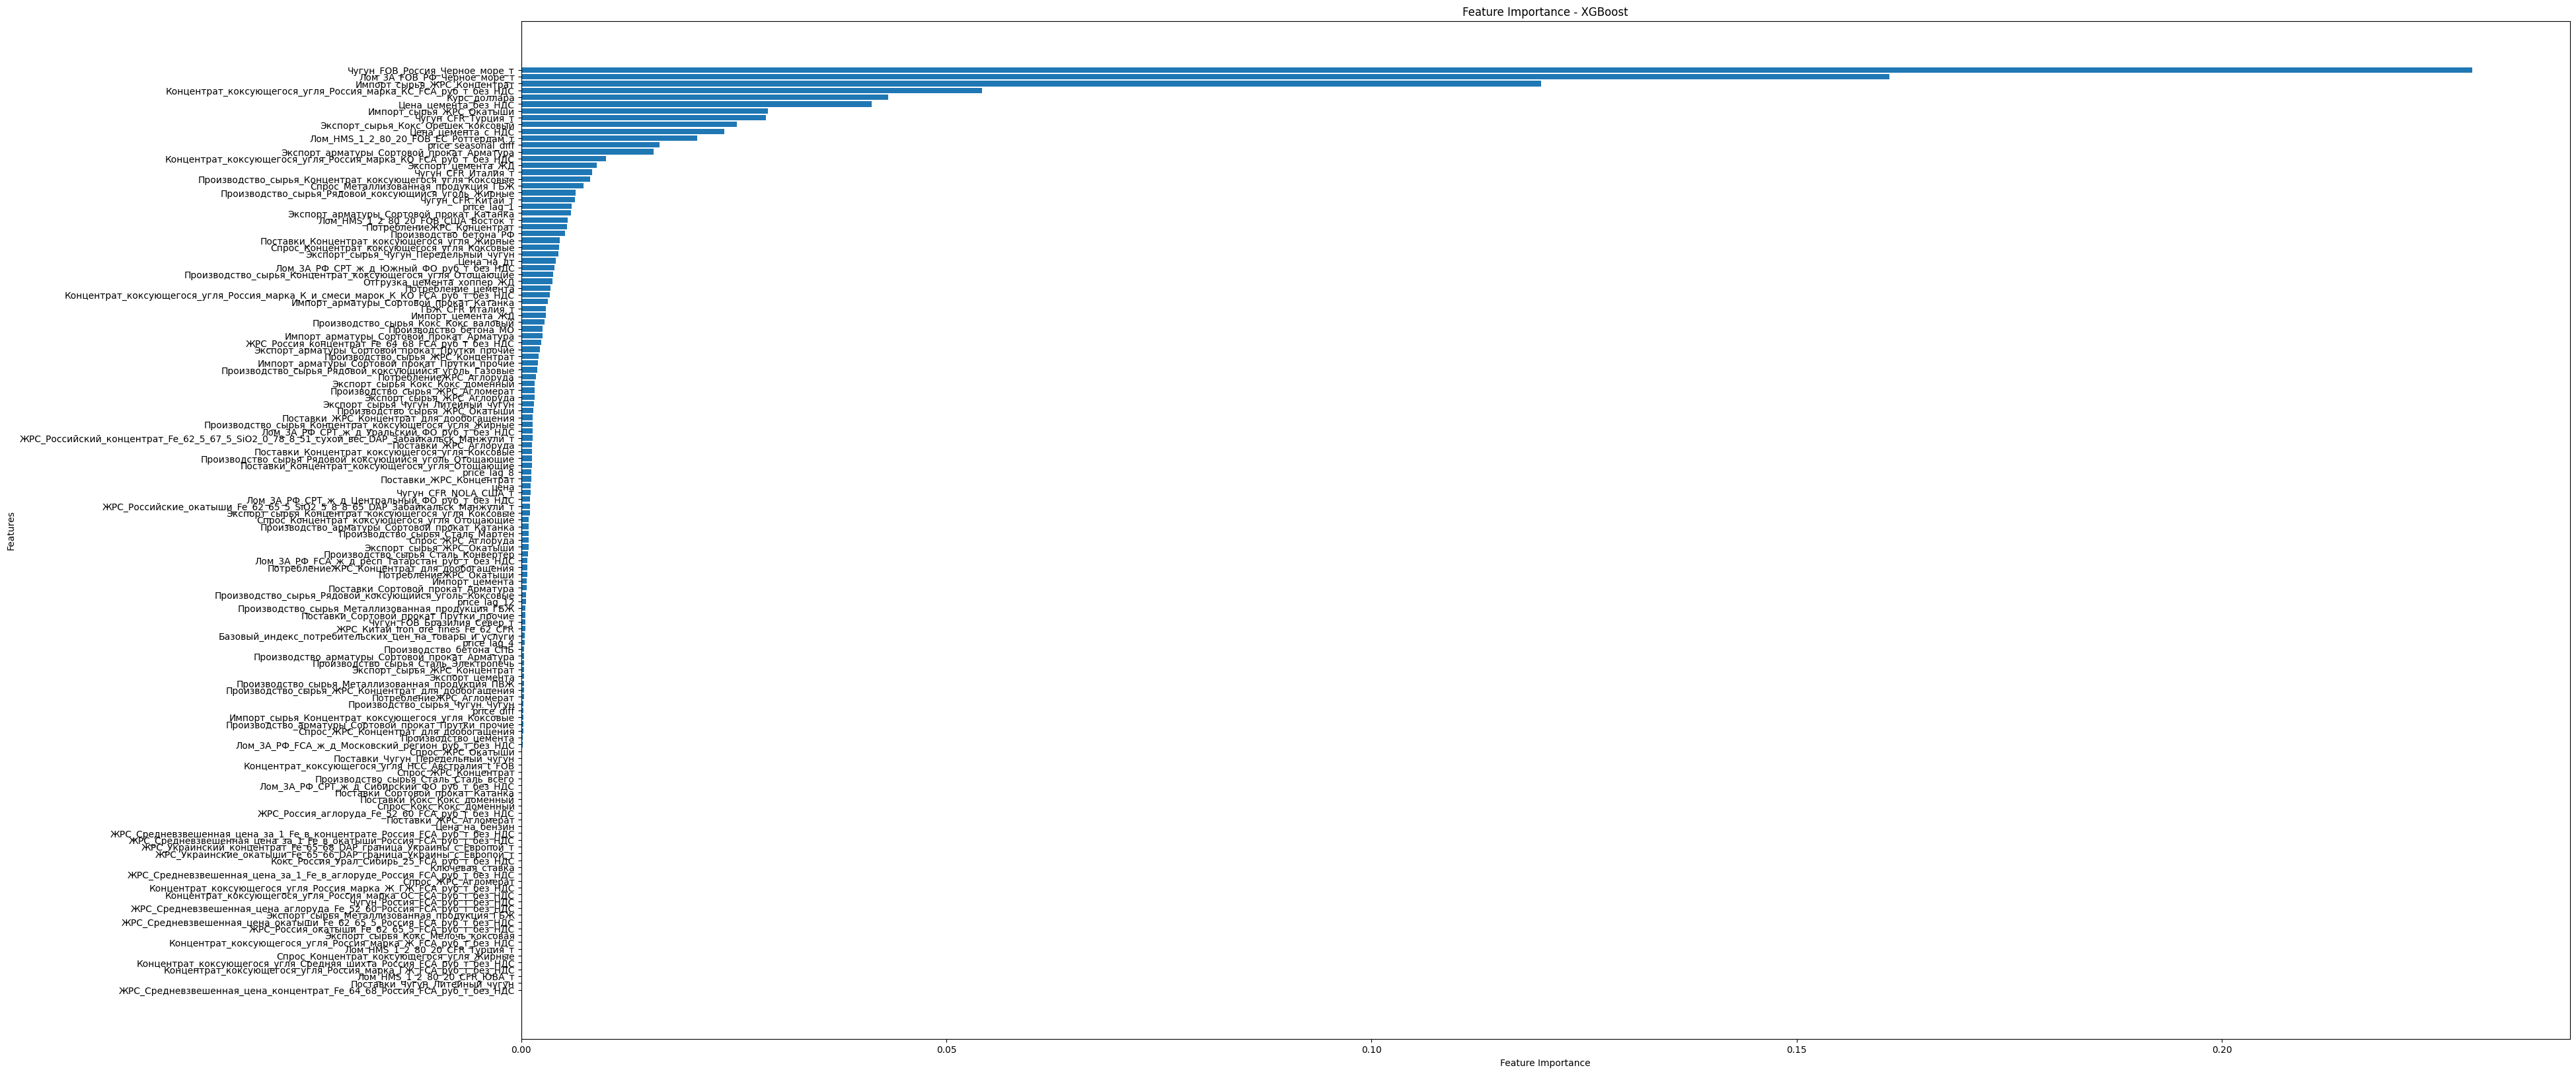

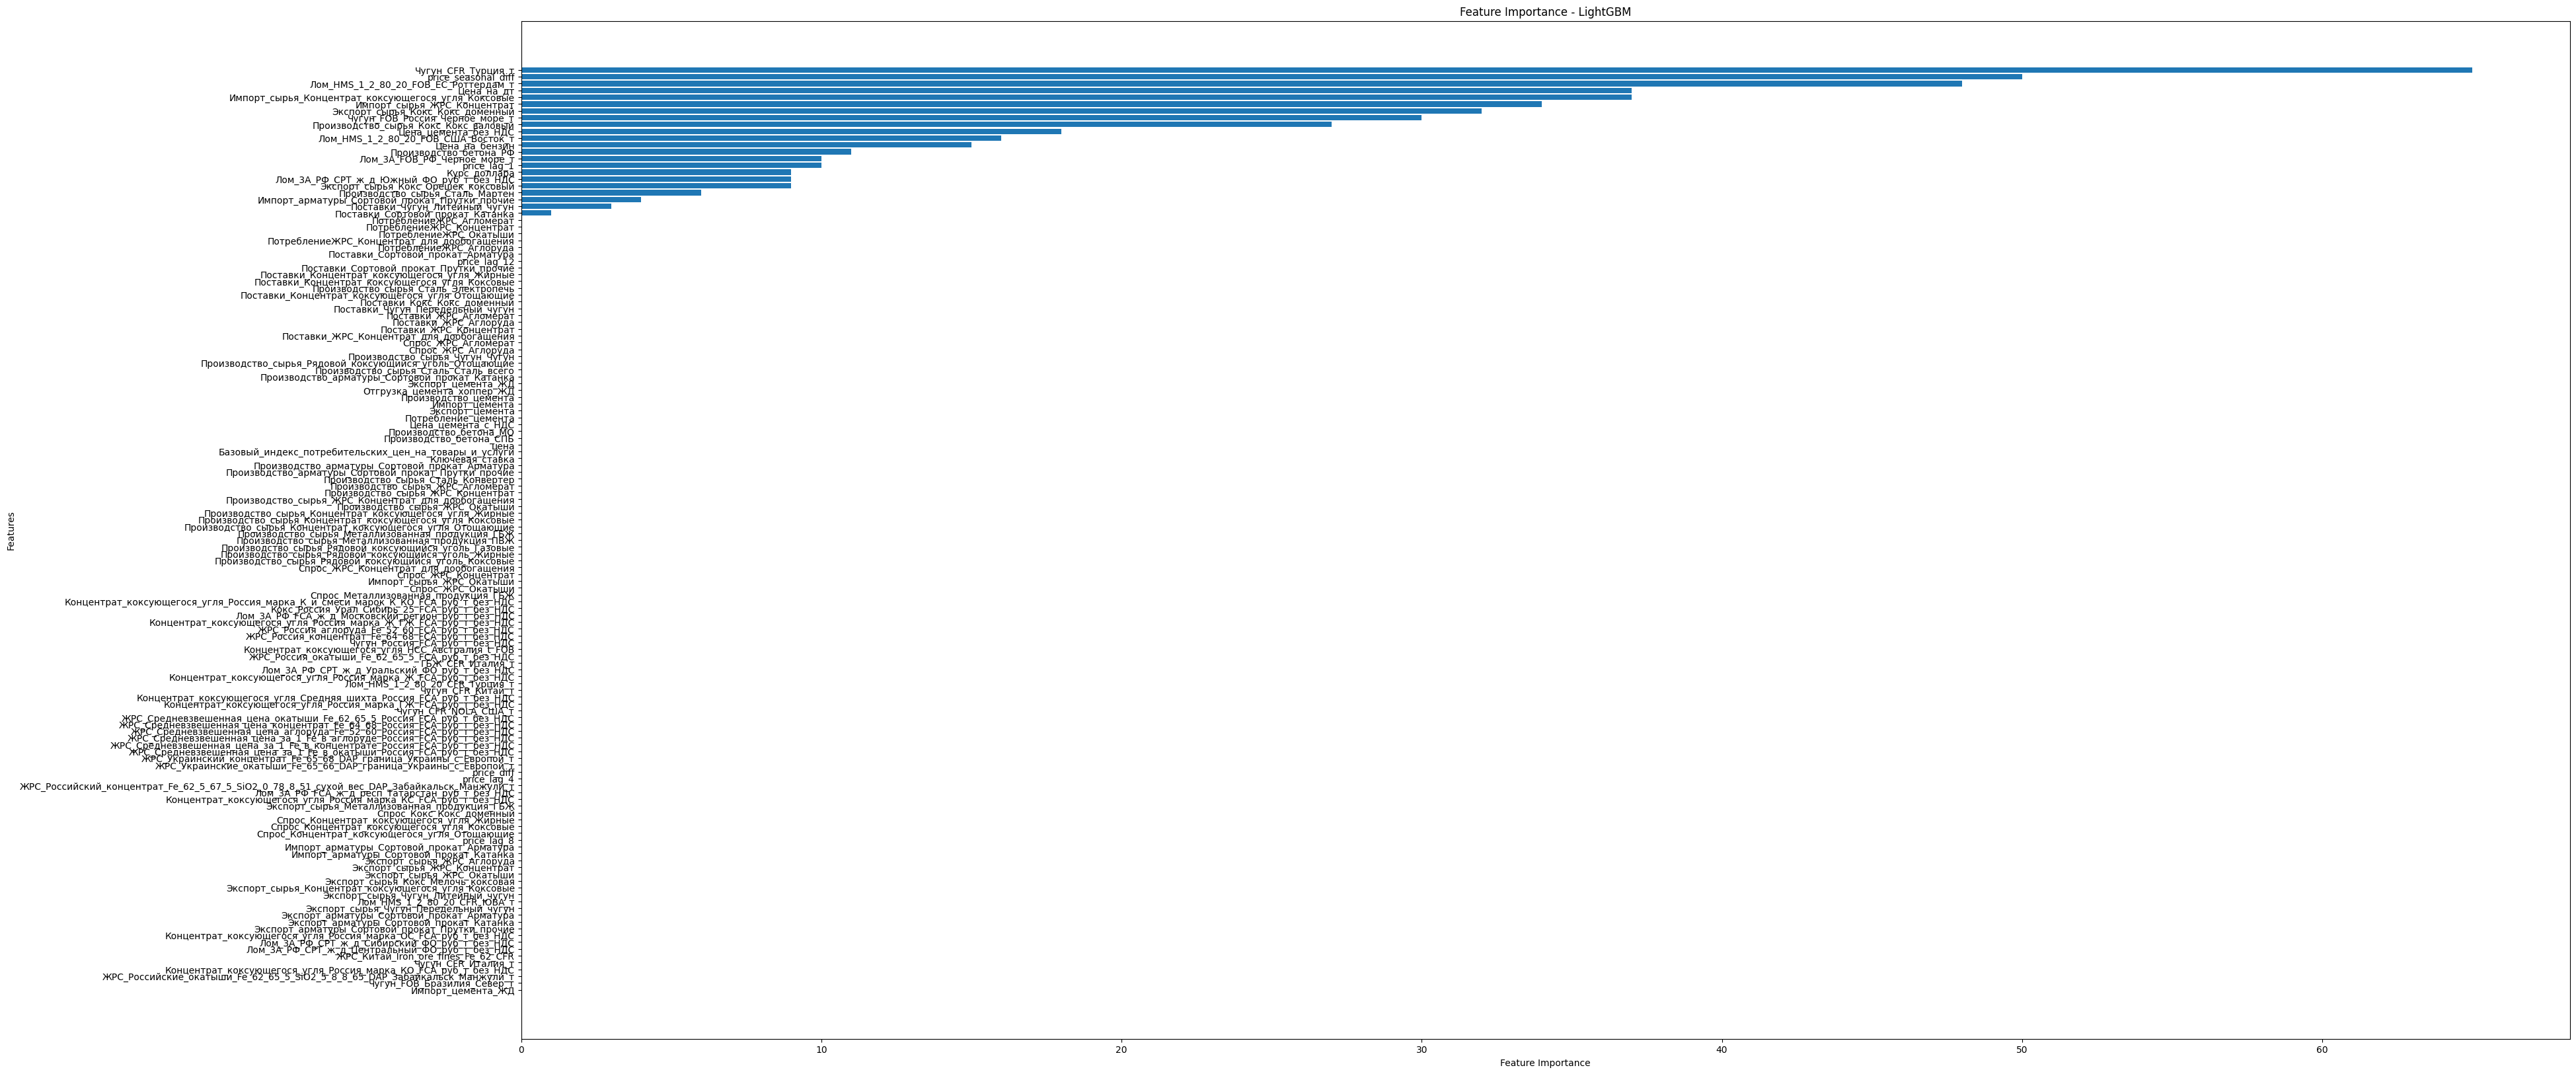

In [32]:
xgb_importance = get_feature_importance_df(xgb_model, X_train.columns, "XGBoost")
lgb_importance = get_feature_importance_df(lgb_model, X_train.columns, "LightGBM")

importance_df = pd.merge(lgb_importance, xgb_importance, on='Feature', how='outer').fillna(0)

In [33]:
importance_df['Average_Importance'] = (importance_df['LightGBM_Importance'] + importance_df['XGBoost_Importance']) / 2
importance_df.describe()

LightGBM_Importance  XGBoost_Importance  Average_Importance
count           136.000000          136.000000          136.000000
mean              3.536765            0.007353            1.772059
std              10.647836            0.026770            5.329013
min               0.000000            0.000000            0.000000
25%               0.000000            0.000124            0.000079
50%               0.000000            0.000887            0.000546
75%               0.000000            0.003184            0.002756
max              65.000000            0.229443           32.514374

Удаляем неважные признаки

In [34]:
importance = importance_df['Average_Importance'].describe().quantile(0.55)
zero_importance = importance_df[(importance_df['Average_Importance'] < importance)]

In [35]:
X_train_filtered = pd.DataFrame(X_train_scaled, columns=X_train.columns).drop(columns=zero_importance['Feature'].values)
X_test_filtered = pd.DataFrame(X_test_scaled, columns=X_test.columns).drop(columns=zero_importance['Feature'].values)

print(f"Удалено {len(zero_importance)} признаков, оставлено {X_train_filtered.shape[1]} признаков.")

Удалено 116 признаков, оставлено 20 признаков.


Создаем стекинг ансамбль

In [36]:
stacking_model = StackingRegressor(
    estimators=[
        ('xgb', xgb_model),
        ('lgb', lgb_model),
        ('cbt', cbt_model)  
    ],
    final_estimator=ElasticNet(alpha=0.5, l1_ratio=0.7, random_state=42), cv=4
)

Обучаем ансамбль

In [37]:
stacking_model.fit(X_train_filtered, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 447
[LightGBM] [Info] Number of data points in the train set: 68, number of used features: 20
[LightGBM] [Info] Start training from score 57902.941176
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

StackingRegressor(cv=4,
                  estimators=[('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None, gamma=0.1,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_cons...
                                            max_leaves=None, min_child_weight=3,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=300, n_jobs=None,
                                            num_parallel_tree=None, ...)),
                              ('lgb',
                               LGBMRegressor(learning_rate=0.01, max_depth=6,
                                             n_estimators=300,
                                             random_state=42)),
                              ('cbt',
                               <catboost.core.CatBoostRegressor object at 0x000002C5FEC26D80>)],
                  final_estimator=ElasticNet(alpha=0.5, l1_ratio=0.7,
                                             random_state=42))

Предсказываем и оцениваем точность

In [38]:
y_pred = stacking_model.predict(X_test_filtered)

print('-----------------------------------------------------------------------------------------------------------------------------------------')
mae = mean_absolute_error(y_test, y_pred)
print(f'MAE: {mae}')


print('-----------------------------------------------------------------------------------------------------------------------------------------')
r2 = r2_score(y_test, y_pred)
print(f"R^2: {r2}")

-----------------------------------------------------------------------------------------------------------------------------------------
MAE: 1423.6214210124501
-----------------------------------------------------------------------------------------------------------------------------------------
R^2: 0.8480035107575493


Сохраняем модель

In [40]:
joblib.dump(stacking_model, "../models/stacking_model.pkl")
df_cleaned.to_csv('../data/df_cleaned.csv')

График точности предсказаний

<Axes: >

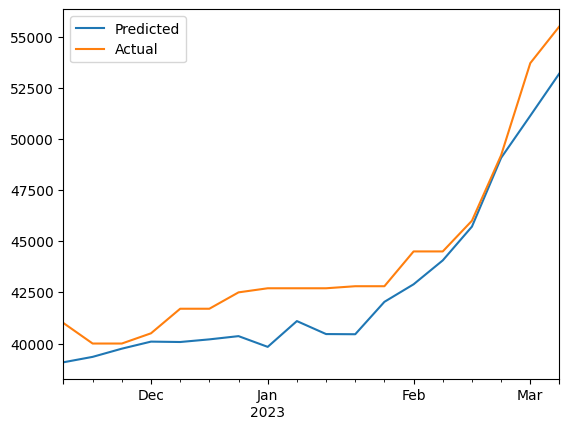

In [41]:
pres_test_data = pd.DataFrame(y_pred, index=y_test.index, columns=['Predicted'])
pres_test_data['Actual'] = y_test
pres_test_data.plot()

Создаем вторую - одномерную моедль

In [42]:
data_oned = pd.read_csv("../data/price_data.csv")
data_oned.drop(columns='Unnamed: 0', inplace=True)

In [43]:
print(data_oned.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 428 entries, 0 to 427
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   dt                428 non-null    object
 1   Цена на арматуру  428 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 6.8+ KB
None


In [44]:
data_oned.set_index('dt', inplace=True)

In [45]:
data_oned.head()

Цена на арматуру
dt                          
2015-01-05             32900
2015-01-12             32500
2015-01-19             32000
2015-01-26             30700
2015-02-02             30300

In [46]:
# Создание лагов
lags = 6
for i in range(1, lags + 1):
    data_oned[f'lag_{i}'] = data_oned['Цена на арматуру'].shift(i)

# Удаление NaN после лагов
data_oned = data_oned.dropna()

In [47]:
# Разделение на train и test
train_size = int(len(data_oned) * 0.8)
train = data_oned[:train_size]
test = data_oned[train_size:]

In [48]:
# Фичи и таргет
X_train = train.drop(['Цена на арматуру'], axis=1)
y_train = train['Цена на арматуру']
X_test = test.drop(['Цена на арматуру'], axis=1)
y_test = test['Цена на арматуру']


In [49]:
model = CatBoostRegressor(iterations=1000, 
                          learning_rate=0.05, 
                          depth=6, 
                          random_seed=42, 
                          verbose=100)
model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50)

0:	learn: 10048.3350549	test: 21185.4058319	best: 21185.4058319 (0)	total: 11.6ms	remaining: 11.6s
100:	learn: 1404.9879605	test: 4633.2421051	best: 4269.3213207 (62)	total: 98.2ms	remaining: 874ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 4269.321321
bestIteration = 62

Shrink model to first 63 iterations.


In [50]:
# Предсказания
y_pred = model.predict(X_test)

In [51]:
# Метрики
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MAE: {mae:.2f}')
print(f'R²: {r2:.4f}')

MAE: 2999.34
R²: 0.8591


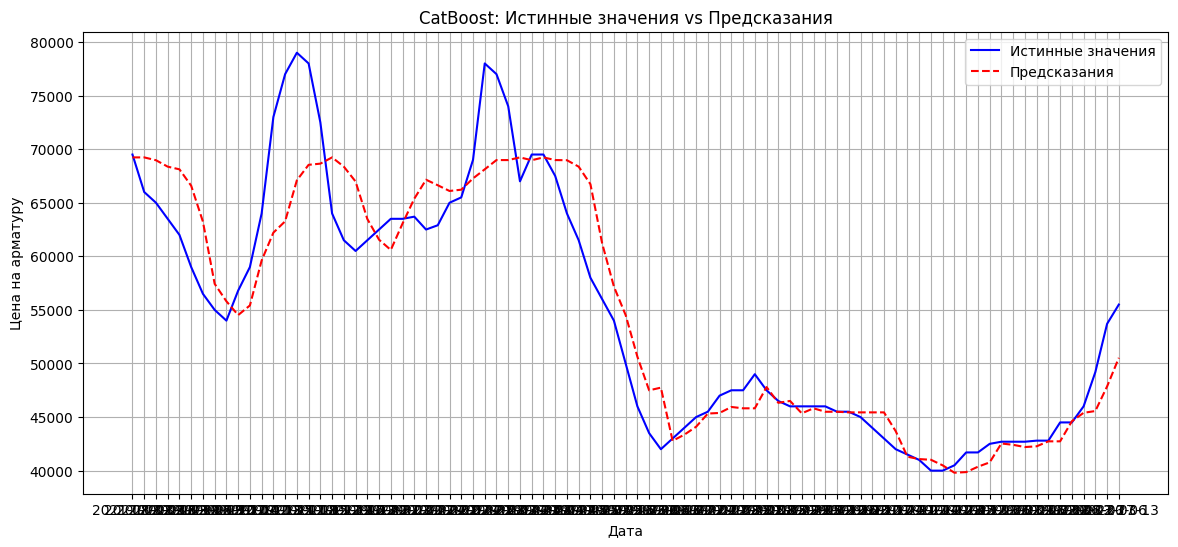

In [52]:
# Визуализация
plt.figure(figsize=(14, 6))
plt.plot(test.index, y_test, label='Истинные значения', color='blue')
plt.plot(test.index, y_pred, label='Предсказания', color='red', linestyle='--')
plt.xlabel('Дата')
plt.ylabel('Цена на арматуру')
plt.title('CatBoost: Истинные значения vs Предсказания')
plt.legend()
plt.grid(True)
plt.show()


In [54]:
joblib.dump(model, "../models/model_oned.pkl")

['../models/model_oned.pkl']